In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.neighbors import NearestNeighbors

# Unsupervised Gender Classification Using Word Embeddings

The main task is to predict the gender from personal data considering an extract of data of the French census from the years 1836 to 1936. Let us import the data

In [2]:
data = pd.read_csv('data/transcriptions_with_sex.csv', sep=',')
data.head(5)

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


We also have access to a dataset that list the names of people with the number of people per gender. This will be later useful to transform names into embedded vectors.

In [3]:
names_df = pd.read_csv('data/firstname_with_sex.csv', sep=';')
names_df.head(5)

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


We are interested on using a Word embedding model, so for this we will use the library `spacy`. We considered the libraries fr_core_news_sm that weights 15 MB and fr_core_news_lg that weights 545 MB. Both libraries have their origin from news articles among other media texts. More information can be found on https://spacy.io/models/fr. We download these libraries by using:

In [246]:
!python -m spacy download fr_core_news_sm
#!python -m spacy download fr_core_news_lg

     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
      --------------------------------------- 0.2/16.3 MB 6.9 MB/s eta 0:00:03
     - -------------------------------------- 0.7/16.3 MB 8.8 MB/s eta 0:00:02
     -- ------------------------------------- 1.0/16.3 MB 7.7 MB/s eta 0:00:02
     -- ------------------------------------- 1.2/16.3 MB 6.2 MB/s eta 0:00:03
     --- ------------------------------------ 1.5/16.3 MB 6.9 MB/s eta 0:00:03
     ---- ----------------------------------- 2.0/16.3 MB 6.9 MB/s eta 0:00:03
     ----- ---------------------------------- 2.4/16.3 MB 7.3 MB/s eta 0:00:02
     ------- -------------------------------- 2.9/16.3 MB 7.6 MB/s eta 0:00:02
     -------- ------------------------------- 3.3/16.3 MB 8.2 MB/s eta 0:00:02
     --------- ------------------------------ 4.0/16.3 MB 8.5 MB/s eta 0:00:02
     ----------- ---------------------------- 4.6/16.3 MB 8.6 MB/s eta 0:00:02
     ------------ --------------------------- 5.1/16.3 MB 8

We then load the embedding and proceed to define the target labels, in our case this is 'homme' and 'femme' 

In [33]:
nlp = spacy.load("fr_core_news_lg")
H_LABEL = nlp('homme')
F_LABEL = nlp('femme')
n_embedding = len(H_LABEL.vector)
print("Embedding size: {}".format(n_embedding))

Embedding size: 300


It is easier to extract information from tables, so the next step is to transform the data into a `DataFrame`, having into accound that not all features have values for all columns, so we have to fill in with None. All the fields contained in our dataset are included in the list `key_names`. 

In [34]:
key_names = ['surname', 'firstname', 'occupation', 'link', 'age', 'employer', 'civil_status', 'birth_date', 'lob']
n_keys = len(key_names)
dic = {k:[] for k in key_names}

# Transforming into tabular data
for phrase in data['groundtruth']:
    phrase = phrase.lower()
    indices = {}
    for word in key_names:
        pattern = word + ': '
        idx = phrase.find(pattern)
        if idx != -1:
            indices[word] = idx
    indices = dict(sorted(indices.items(), key=lambda item: item[1]))

    values = list(indices.values())
    values.append(len(phrase))
    keys = indices.keys()
    for i, key in enumerate(keys):
        dic[key].append(phrase[values[i]:values[i+1]].split(':')[1].strip())
        i += 1
  
    # set to NAN values not contained    
    for key in set(key_names) - set(keys):
        dic[key].append(None)    

data_df = pd.DataFrame(dic)
data_df.head(15)

,surname,firstname,occupation,link,age,employer,civil_status,birth_date,lob
0,chardon,marie,idem,fille,30,None,None,None,None
1,lhopital,louis-jean,sp,chef,67,None,None,None,None
2,papin,marie,idem,idem,15,idem,None,None,None
3,lavocat,marie,None,femme,None,None,None,1875,rigny
4,benne,marguerite,None,None,78,None,None,None,None
5,roy,antoine,métayer patron,chef de ménage,51 ans,None,None,None,None
6,bizet,louis,None,idem,9,None,None,None,None
7,garitat,jules,None,fils,12,None,None,None,None
8,souche,maria,idem,idem,4 mois,None,None,None,None
9,guichou,elisabeth,néant,femme,28,None,None,None,None


## Data cleaning
There are several entrie values that need to be standardazided or removed. This is perform in the following lines of code

In [35]:
# Standardzing values from column occupation
def unique_values(lista, string):
    vec = []
    for word in lista:
        try:
            if word.startswith(string):
                vec.append(word)
        except: pass  
    return vec    

# Setting a class to a unique value in column occupation
lista_occupation = unique_values(data_df['occupation'].unique(), 's')
lista_occupation.remove('sellier')   
data_df.replace(lista_occupation, 'sans profession', inplace=True)
# Setting a class to a unique value in column link
lista_link = unique_values(data_df['link'].unique(), 'ch')
data_df.replace(lista_link, 'chef', inplace=True)
# Removing the word idem
data_df.replace('idem', None, inplace=True)
# Removing particles
#vals =['sa', 'son', 'ses', 'de']
#data_df.replace(vals, '', inplace=True)

To predict the gender, there are several columns that do not have important importance for its prediction. So we need to remove some columns. At the end we keep only 3: Firstname, Occupation and link (Family link)

In [36]:
cols_to_drop = ['surname', 'age', 'employer', 'civil_status', 'birth_date', 'lob']
data_df.drop(cols_to_drop, axis=1, inplace=True)
n_df = data_df.shape[0]  
data_df.head(20)

,firstname,occupation,link
0,marie,None,fille
1,louis-jean,sans profession,chef
2,marie,None,None
3,marie,None,femme
4,marguerite,None,None
5,antoine,métayer patron,chef
6,louis,None,None
7,jules,None,fils
8,maria,None,None
9,elisabeth,néant,femme


## Modeling
We will need to perform different transformations, including transforming words into numerical vectors, the functions below permits just do that

In [38]:
def vector_names(names, prenoms):
    """ Function to transform names into embedding vectors. This is achieved by considering 
        the frequency for each gender weight in the embedded words homme and femme
    """
    array, probabilities = [], []
    for name in names.split(' '):
        try:
            probabilities.append(prenoms[prenoms['firstname'] == name]['p_female'].values[0])
        except:
            probabilities = None

        if probabilities:
            func = []
            for probs in probabilities:
                for i in range(n_embedding):
                    func.append(probs * F_LABEL.vector[i] + (1 - probs) * H_LABEL.vector[i])
                array.append(np.array(func))
            array = np.array(array).mean(axis=0)    
            return [array]
        else:
             return []

def remove_nan(sentence):
    """ Function to remove Nan values
    """
    words = []
    for word in sentence:
        if word is not None:
            words.append(word)
    return ' '.join(words)        

def word_embedding(sentence, names_df):
    """ Function to transform a phrase to numbers by using its embeddings.
        The output is the average of this vectors 
    """
    name = sentence[0]
    if name is not None:
        name = name.replace('-', ' ')
        vec = vector_names(name, names_df) # Treating person's name
        sentence = remove_nan(sentence[1:])
    else:
        vec = []
        sentence = remove_nan(sentence)
    doc = nlp(sentence) # Getting vector embeddings
    for X in doc:
        vec.append(X.vector)

    centroid = np.array(vec).mean(axis=0)  
    return centroid

def gender_classifier(df, dic, names_df, ref_labels):
    """ Function to predict the gender from personal information, calculating
        the proximity to the target labels 'homme' and 'femme'
    """
    label_vectors = list(dic.values())
    label_classes = list(dic.keys())
    # Initialization nearest neighbors algorithm
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(label_vectors)
    # Classification
    accuracy = 0 
    prediction, post_analysis = [], []
    for i, values in enumerate(df): 
        vec = word_embedding(values, names_df)
        idx_label = neigh.kneighbors([vec], return_distance=False)[0, 0]
        pred = str(label_classes[idx_label])
        prediction.append(pred)
        if ref_labels[i] == pred:
            accuracy += 1
        else:
            post_analysis.append([values, pred])
    accuracy = round(100 * accuracy / len(ref_labels), 1)
    # Saving predicted classification
    pred_df = pd.DataFrame({'prediction_embed.':prediction})
    pd.concat([pred_df, ref_labels], axis=1).to_csv('results/gender_pred.csv')          
    return prediction, accuracy, post_analysis    

## Results

In [39]:
# Transforming the names_df dataset to get frequencies instead of absolute values
prenoms = names_df.copy()
prenoms['p_female'] = prenoms['female'] / (prenoms['male'] + prenoms['female'])
prenoms.drop(['male', 'female'], axis=1, inplace=True)
# Defining a dictionary containing the labels and embedded vectors
label_dic = {H_LABEL: H_LABEL.vector, F_LABEL:F_LABEL.vector}
# Reference predictions
ref_labels = data['sex']    

_, accuracy, post_analysis = gender_classifier(data_df.values, label_dic, prenoms, ref_labels)

print("The similarity to the reference predictions is of about {}%".format(accuracy))

The similarity to the reference predictions is of about 95.0%


In [31]:
# Wrong values
for wrongs in post_analysis:
    print(*wrongs)

['claude' 'journalier' 'chef'] homme
['jeanne' None 'chef'] femme
['claude' 'cultivateur' 'chef'] homme
['branislav' 'manoeuvre' 'frère'] femme
['marie' None 'chef'] femme
['emile' None None] homme
['marie' None None] femme
['rolland' 'nourrisson' 'assisté de la s.'] femme
['marie' 'cultivatrice' 'domestique'] femme
['claude' 'sans profession' 'enfant'] homme
['antonie' None None] femme
['claude' None None] homme


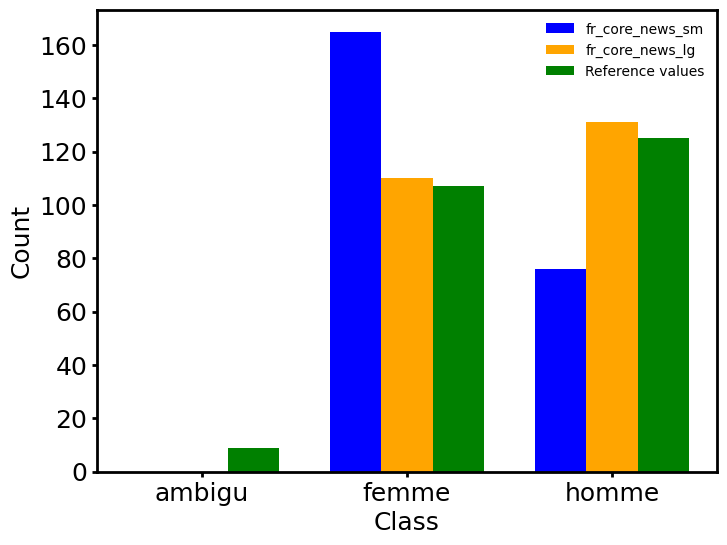

In [32]:
#Loading the data with the results
d1 = pd.read_csv('results/gender_pred-sm.csv').drop(['Unnamed: 0', 'sex'], axis=1)
d2 = pd.read_csv('results/gender_pred-lg.csv').drop('Unnamed: 0', axis=1)

model1_counts = np.unique(d1['prediction_embed.'], return_counts=True)
model2_counts = np.unique(d2['prediction_embed.'], return_counts=True)
ref_counts = np.unique(d2['sex'], return_counts=True)

# Unique classes
classes = np.unique(d2['sex'])
x = np.arange(len(classes))
bar_width = 0.25

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
for val in ["top", "left", "bottom", "right"]:
        ax.spines[val].set_linewidth(2)
        ax.spines[val].set_color("black")
ax.tick_params(axis='both', which='major', width=2, labelsize=18)
# Plotting bars for Model 1
ax.bar(x - bar_width, [model1_counts[1][np.where(model1_counts[0] == c)][0] if c in model1_counts[0] else 0 for c in classes],
        bar_width, color='blue', label='fr_core_news_sm')
# Plotting bars for Model 2
ax.bar(x , [model2_counts[1][np.where(model2_counts[0] == c)][0] if c in model2_counts[0] else 0 for c in classes],
        bar_width, color='orange', label='fr_core_news_lg')
# Reference histogram
ax.bar(x + bar_width, [ref_counts[1][np.where(ref_counts[0] == c)][0] if c in ref_counts[0] else 0 for c in classes],
        bar_width, color='green', label='Reference values')


plt.xlabel('Class', fontsize=18)
plt.ylabel('Count', fontsize=18)
ax.grid(False)
plt.xticks(x, labels=classes)
plt.yticks(np.arange(0, 170, 20))
plt.legend(frameon=False)


plt.show()